In [3]:
# Data handling
import pandas as pd 
import numpy as np

# Clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize

# Dimensionality reduction
from sklearn.decomposition import PCA


# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.style as style
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [4]:
def prepare_pca(n_components, data, kmeans_labels):
    """ prepare pca with n dimension
    """
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_3d(df, name='labels'):
    """ plot 3d scatter
    """
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='x', y='y', z='z',color=name)
    fig.update_traces(marker=dict(size=3))
    fig.show()
    
    
def load_preprocess_data():
    """ Load and preprocess data
    """
    # load dataset
    df = pd.read_csv('data_credit_card_customer_seg.csv')
    
    # handle missing values by replace it by means
    df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(), inplace=True)
    df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean(), inplace=True)
    
    # drop unnecessary column
    df.drop('CUST_ID', axis=1, inplace=True)
    
    return  df

df = load_preprocess_data()
df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.636364    1499.00           1499.00   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000        864.206542          0.000000      12  
4   678.334763        244.791237          0.000000      12

## Data Normalization

In [5]:
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(df) 

In [6]:
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 

## Dimension Reduction using PCA

In [7]:
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
X_principal.head(2)

P1        P2
0 -0.489826 -0.679678
1 -0.518791  0.545011

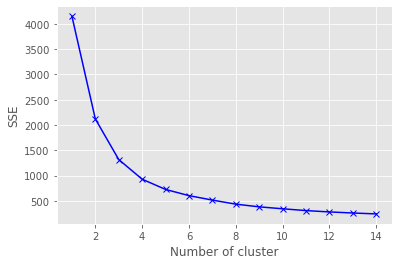

In [8]:
style.use('ggplot')

# Choosing the K value using elbow method 
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_principal)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()),'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

It's hard to find the elbow point of the curve, so we use silhouette score.

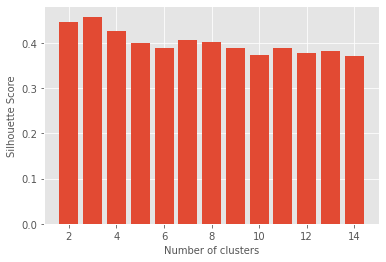

In [9]:
# silhouette score
silhouette_scores = []

for n_cluster in range(2, 15):
    silhouette_scores.append( 
        silhouette_score(X_principal, KMeans(n_clusters = n_cluster).fit_predict(X_principal))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 

plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

Highest silhouette score is k = 3.

# Kmeans clustering

Let's visualize k=3,4

# k=3

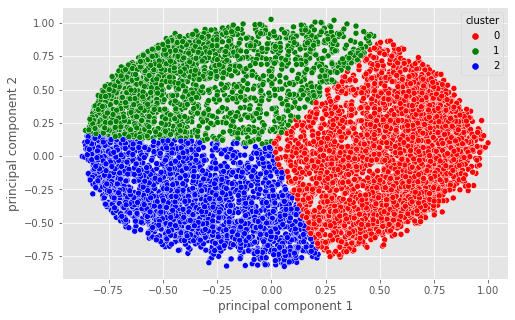

In [11]:
# Kmeans algorithm
kmean= KMeans(n_clusters=3)
kmean.fit(X_principal)
labels=kmean.labels_

# PCA to transform data to 2 dimensions for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized_df)
principalDf = pd.DataFrame(data = principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)

# scatterplot
plt.figure(figsize=(8,5))
ax = sns.scatterplot( data=finalDf,x="principal component 1", y="principal component 2", hue="cluster",palette=['red','green','blue'])
plt.show()

In [12]:
#3D plot
pca_df = prepare_pca(3, normalized_df, labels)
plot_3d(pca_df)

In [13]:
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
clusters['cluster'].value_counts()

0    3743
2    3184
1    2023
Name: cluster, dtype: int64

In [14]:
clusters.groupby('cluster').mean()

BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
cluster                                                                  
0        1078.487175           0.929872  1896.970219       1052.293727   
1        3740.325513           0.959410   554.883688        396.024024   
2         753.327167           0.763247   237.372497        176.640217   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
cluster                                                              
0                    845.083460    197.840523             0.887544   
1                    158.945017   3338.920557             0.262683   
2                     61.043423    397.532378             0.168076   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
cluster                                                                 
0                          0.341719                          0.716416   
1                          0.145069                          0.148000   
2                          0.075210                          0.088179   

         CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  \
cluster                                                            
0                      0.037795          0.714935      28.969810   
1                      0.398879         10.807217       7.216510   
2                      0.082017          1.425251       2.707286   

         CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  \
cluster                                                                  
0         4786.446768  1915.427407        774.803492          0.280978   
1         6513.628874  2900.717958       1654.353950          0.033979   
2         2868.272964   777.022696        467.274197          0.080184   

            TENURE  
cluster             
0        11.610206  
1        11.379140  
2        11.495917

Text(0.5, 0, 'SEGMENTS')

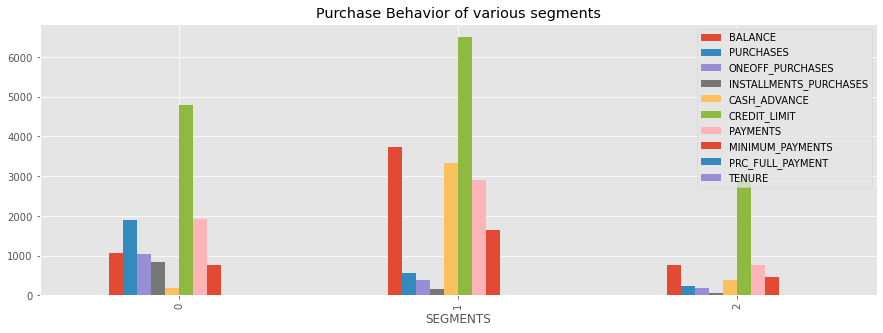

In [15]:
(clusters[['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES',
           'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','CREDIT_LIMIT', 'PAYMENTS', 
           'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT','TENURE', 'cluster']]
 .groupby('cluster').mean().plot.bar(figsize=(15, 5)))
plt.title('Purchase Behavior of various segments')
plt.xlabel('SEGMENTS')

## k=4

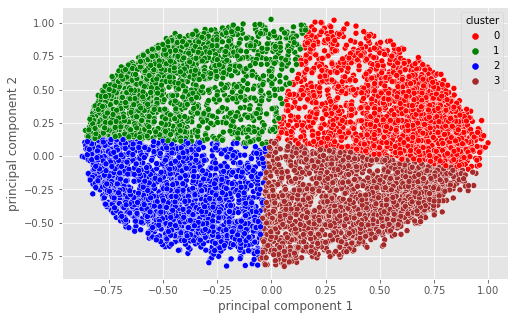

In [16]:
# Kmeans algorithm
kmean= KMeans(n_clusters=4,init='k-means++',n_init=10)
kmean.fit(X_principal)
labels=kmean.labels_

# PCA to transform data to 2 dimensions for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized_df)
principalDf = pd.DataFrame(data = principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)

# scatterplot
plt.figure(figsize=(8,5))
ax = sns.scatterplot(x="principal component 1", y="principal component 2", hue="cluster", data=finalDf,palette=['red','green','blue','brown'])
plt.show()

In [17]:
#3D plot
pca_df = prepare_pca(3, normalized_df, labels)
plot_3d(pca_df)

In [18]:
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
clusters['cluster'].value_counts()

2    2770
3    2409
0    1983
1    1788
Name: cluster, dtype: int64

In [19]:
clusters.groupby('cluster').mean()

BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
cluster                                                                  
0        2237.793226           0.981963  3109.117675       1940.824105   
1        3596.797170           0.956671   308.242036        240.065766   
2         799.025911           0.772149   206.568704        170.328505   
3         381.955428           0.853034   701.523802        229.395068   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
cluster                                                              
0                   1168.618442    744.272107             0.921761   
1                     68.260537   3335.740114             0.174749   
2                     36.418314    436.389853             0.127907   
3                    472.709207     46.451495             0.786232   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
cluster                                                                 
0                          0.562188                          0.692701   
1                          0.102943                          0.078066   
2                          0.071037                          0.053825   
3                          0.131317                          0.663931   

         CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  \
cluster                                                            
0                      0.105304          2.504286      43.037317   
1                      0.403339         10.767338       3.583893   
2                      0.090336          1.570758       2.099278   
3                      0.012172          0.210876      14.149855   

         CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  \
cluster                                                                  
0         6992.512263  3318.837018       1305.375142          0.213684   
1         6276.549895  2699.438917       1586.252653          0.032710   
2         2823.952268   781.037354        481.001474          0.051237   
3         3036.260593   805.443510        405.768294          0.311997   

            TENURE  
cluster             
0        11.790217  
1        11.341163  
2        11.475090  
3        11.471980

Text(0.5, 0, 'SEGMENTS')

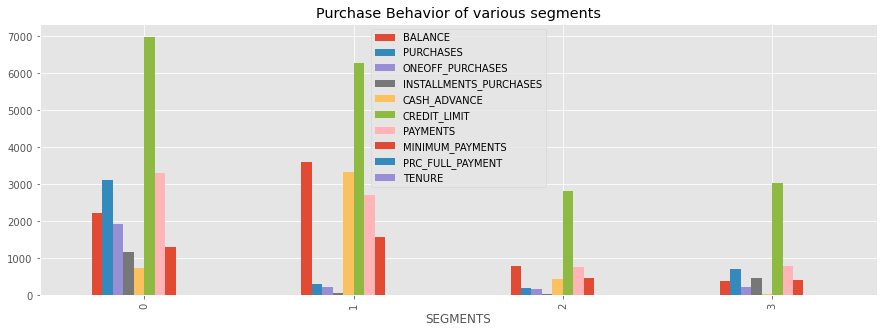

In [20]:
(clusters[['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES',
           'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','CREDIT_LIMIT', 'PAYMENTS', 
           'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT','TENURE', 'cluster']]
 .groupby('cluster').mean().plot.bar(figsize=(15, 5)))
plt.title('Purchase Behavior of various segments')
plt.xlabel('SEGMENTS')